In [1]:
import ccxt
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
#EXTRACTING BTC FROM BINANCE
exch = 'binance' # initial exchange
t_frame = '1d' # 1-day timeframe, usually from 1-minute to 1-week depending on the exchange
symbol = 'ADA/BTC' # initial symbol
#figure out coinbase, , 'bitstamp', 'bitflyer', 'gemini', 'itbit', 'bittrex'
exchange_list = ['binance','bitfinex','kraken','poloniex']
 
# Get our Exchange
try:
    exchange = getattr (ccxt, exch) ()
except AttributeError:
    print('-'*36,' ERROR ','-'*35)
    print('Exchange "{}" not found. Please check the exchange is supported.'.format(exch))
    print('-'*80)
    quit()
 
# Check if fetching of OHLC Data is supported
if exchange.has["fetchOHLCV"] != True:
    print('-'*36,' ERROR ','-'*35)
    print('{} does not support fetching OHLC data. Please use another  exchange'.format(exch))
    print('-'*80)
    quit()
 
# Check requested timeframe is available. If not return a helpful error.
if (not hasattr(exchange, 'timeframes')) or (t_frame not in exchange.timeframes):
    print('-'*36,' ERROR ','-'*35)
    print('The requested timeframe ({}) is not available from {}\n'.format(t_frame,exch))
    print('Available timeframes are:')
    for key in exchange.timeframes.keys():
        print('  - ' + key)
    print('-'*80)
    quit()
 
# Check if the symbol is available on the Exchange
exchange.load_markets()
if symbol not in exchange.symbols:
    print('-'*36,' ERROR ','-'*35)
    print('The requested symbol ({}) is not available from {}\n'.format(symbol,exch))
    print('Available symbols are:')
    for key in exchange.symbols:
        print('  - ' + key)
    print('-'*80)
    quit()
 
 


In [3]:
#MORE DATA EXTRACTION
# Get data
data = exchange.fetch_ohlcv(symbol, t_frame)
header = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
df = pd.DataFrame(data, columns=header).set_index('Timestamp')
df['symbol'] = symbol
syms = [symbol]
filename = '{}.csv'.format(t_frame)
exchange_map = defaultdict(list)
for exch in exchange_list:
    try:
        exchange = getattr (ccxt, exch) ()
    except AttributeError:
        print('-'*36,' ERROR ','-'*35)
        print('Exchange "{}" not found. Please check the exchange is supported.'.format(exch))
        print('-'*80)
        quit()
    if exchange.has["fetchOHLCV"] != True:
        print('-'*36,' ERROR ','-'*35)
        print('{} does not support fetching OHLC data. Please use another exchange'.format(exch))
        print('-'*80)
        quit()
    if (not hasattr(exchange, 'timeframes')) or (t_frame not in exchange.timeframes):
        print('-'*36,' ERROR ','-'*35)
        print('The requested timeframe ({}) is not available from {}\n'.format(t_frame,exch))
        print('Available timeframes are:')
        for key in exchange.timeframes.keys():
            print('  - ' + key)
        print('-'*80)
        quit()
    exchange.load_markets()
    for coin in exchange.symbols:
        if coin in syms or coin[-3:] != 'BTC':
            continue
        else:
            try:
                data = exchange.fetch_ohlcv(coin, t_frame)
            except:
                continue
            data_df = pd.DataFrame(data, columns=header).set_index('Timestamp')
            data_df['symbol'] = coin
            df = df.append(data_df)
            syms.append(coin)
            exchange_map[exch] = [pd.to_datetime(data_df.index/1000, unit='s'), data_df.Close]
df.index = df.index/1000 #Timestamp is 1000 times bigger than it should be in this case
df['Date'] = pd.to_datetime(df.index,unit='s')

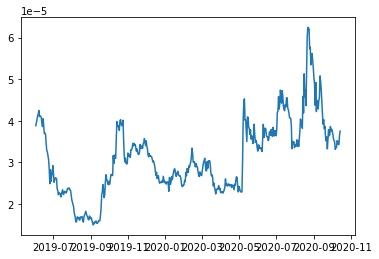

In [22]:
#BINANCE BTC PLOT
plt.plot(exchange_map["binance"][0], exchange_map["binance"][1])

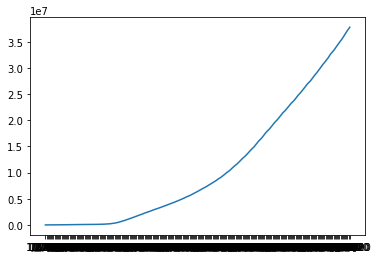

In [23]:
#GLOBAL CONFIRMED COVID CASES PLOT
global_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
gc_df = pd.read_csv(global_cases_url, error_bad_lines=False)
plt.plot(gc_df.iloc[0:, 4:].sum(axis=0))

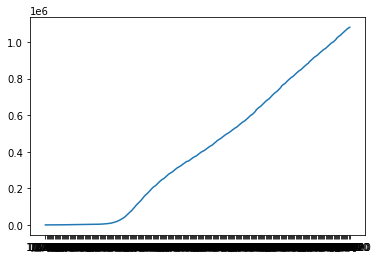

In [24]:
#GLOBAL CONFIRMED COVID DEATHS PLOT
global_deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
gd_df = pd.read_csv(global_deaths_url, error_bad_lines=False)
plt.plot(gd_df.iloc[0:, 4:].sum(axis=0))

In [25]:
#DATASET OF BTC AND COVID CASES FROM 1/22 TO YESTERDAY
confirmed_cases = gc_df.iloc[0:, 4:].sum(axis=0).shift(1)
confirmed_cases[0] = 0


binance = exchange_map["binance"][1].iloc[235:-1]
print(binance)

binance_shifted = binance.shift(-1)
binance_shifted.iloc[-1] = 0
print(binance_shifted)


Timestamp
1579824000000    0.000027
1579910400000    0.000027
1579996800000    0.000027
1580083200000    0.000026
1580169600000    0.000025
                   ...   
1602201600000    0.000035
1602288000000    0.000035
1602374400000    0.000034
1602460800000    0.000034
1602547200000    0.000037
Name: Close, Length: 264, dtype: float64
Timestamp
1579824000000    0.000027
1579910400000    0.000027
1579996800000    0.000026
1580083200000    0.000025
1580169600000    0.000024
                   ...   
1602201600000    0.000035
1602288000000    0.000034
1602374400000    0.000034
1602460800000    0.000037
1602547200000    0.000000
Name: Close, Length: 264, dtype: float64


In [26]:
import numpy as np
import keras
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation, LSTM, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [27]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [28]:
#RNN FOR COVID CASES AS PREDICTOR FOR BTC PRICE
# scaler = MinMaxScaler(feature_range=(0, 1))
# # dataset = scaler.fit_transform(dataset)
# # print(dataset)
# # split into train and test sets
datapoints = len(binance)
# train_size = int(datapoints*0.75)
# test_size = datapoints-train_size
# print(train_size)
# print(test_size)

# train = [dataset.Binance[:train_size].values, dataset.COVID[datapoints:datapoints+train_size].values]
# test = [dataset.Binance[train_size:datapoints].values, dataset.COVID[datapoints+train_size:].values]
# scaler.fit_transform(train)
# scaler.fit_transform(test)

# trainX, trainY = train[0], train[1]
# testX, testY = test[0], test[1]

# # reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, 1))
# testX = np.reshape(testX, (testX.shape[0], 1, 1))
# # create and fit the LSTM network


In [29]:
#RNN FOR DOW JONES INDEX CASES AS PREDICTOR FOR BTC PRICE
import yfinance as yf
import time
from datetime import date, timedelta

In [30]:
dji = yf.Ticker("^GSPC")
# dji.info
dow = dji.history(interval="1d", start="2020-01-22", end=date.today() - timedelta(days=1)).Close

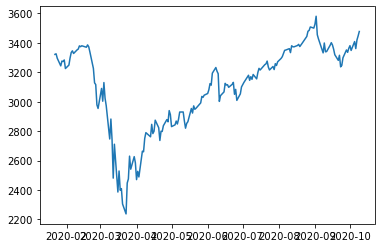

In [31]:
#PLOT OF DJI
plt.plot(dow)

In [32]:
#FILL MISSING DAILY VALUES WITH PREVIOUS DAY'S VAL
date_index = pd.date_range('1/22/2020', periods=datapoints, freq='D')
dow = dow.reindex(index=date_index)
binance = pd.Series(data = binance.values, index = date_index)
binance_shifted = pd.Series(data = binance_shifted.values, index = date_index)
for idx in range(len(dow)):
    if np.isnan(dow[idx]):
        dow[idx] = dow[idx-1]

dataset = pd.DataFrame({'Binance Shifted': binance_shifted, 'Binance': binance, 'DJI': dow})

print(dataset)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset.values)
print(scaled)

            Binance Shifted   Binance          DJI
2020-01-22         0.000027  0.000027  3321.750000
2020-01-23         0.000027  0.000027  3325.540039
2020-01-24         0.000026  0.000027  3295.469971
2020-01-25         0.000025  0.000026  3295.469971
2020-01-26         0.000024  0.000025  3295.469971
...                     ...       ...          ...
2020-10-07         0.000035  0.000035  3419.439941
2020-10-08         0.000034  0.000035  3446.830078
2020-10-09         0.000034  0.000034  3477.139893
2020-10-10         0.000037  0.000034  3477.139893
2020-10-11         0.000000  0.000037  3477.139893

[264 rows x 3 columns]
[[0.42845711 0.10916812 0.80714431]
 [0.42845711 0.10791906 0.80996545]
 [0.41565301 0.10791906 0.78758257]
 [0.39580666 0.08793405 0.78758257]
 [0.38764405 0.05695728 0.78758257]
 [0.39276569 0.04421684 0.748995  ]
 [0.39068502 0.05221084 0.77326858]
 [0.39564661 0.04896328 0.77115454]
 [0.41085147 0.05670747 0.77879166]
 [0.40620999 0.08043967 0.73551478]
 [0.

In [33]:
#RNN PREPROCESSING

# split into train and test sets
values = scaled

datapoints = len(binance)
train_size = int(datapoints*0.60)
test_size = datapoints-train_size

train = values[:train_size, :]
test = values[train_size:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# split into train and test sets



# train = [dataset.Binance[:train_size].values, dow[:train_size].values]
# test = [dataset.Binance[train_size:datapoints].values, dow[train_size:].values]
# scaler.fit_transform(train)

# # scaler.fit_transform(test)
# trainX, trainY = train[0], train[1]
# testX, testY = test[0], test[1]

# # reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, 1))
# testX = np.reshape(testX, (testX.shape[0], 1, 1))
# # create and fit the LSTM network


(158, 1, 2) (158,) (106, 1, 2) (106,)


In [41]:
#RNN ARCHITECTURE
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=40, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history


Epoch 1/40
10/10 - 0s - loss: 0.5235 - val_loss: 0.7615
Epoch 2/40
10/10 - 0s - loss: 0.4709 - val_loss: 0.6932
Epoch 3/40
10/10 - 0s - loss: 0.4190 - val_loss: 0.6225
Epoch 4/40
10/10 - 0s - loss: 0.3660 - val_loss: 0.5476
Epoch 5/40
10/10 - 0s - loss: 0.3131 - val_loss: 0.4685
Epoch 6/40
10/10 - 0s - loss: 0.2619 - val_loss: 0.3842
Epoch 7/40
10/10 - 0s - loss: 0.2119 - val_loss: 0.2969
Epoch 8/40
10/10 - 0s - loss: 0.1756 - val_loss: 0.2165
Epoch 9/40
10/10 - 0s - loss: 0.1590 - val_loss: 0.1610
Epoch 10/40
10/10 - 0s - loss: 0.1554 - val_loss: 0.1405
Epoch 11/40
10/10 - 0s - loss: 0.1542 - val_loss: 0.1351
Epoch 12/40
10/10 - 0s - loss: 0.1534 - val_loss: 0.1365
Epoch 13/40
10/10 - 0s - loss: 0.1529 - val_loss: 0.1387
Epoch 14/40
10/10 - 0s - loss: 0.1530 - val_loss: 0.1399
Epoch 15/40
10/10 - 0s - loss: 0.1530 - val_loss: 0.1404
Epoch 16/40
10/10 - 0s - loss: 0.1530 - val_loss: 0.1407
Epoch 17/40
10/10 - 0s - loss: 0.1530 - val_loss: 0.1410
Epoch 18/40
10/10 - 0s - loss: 0.1530 - 

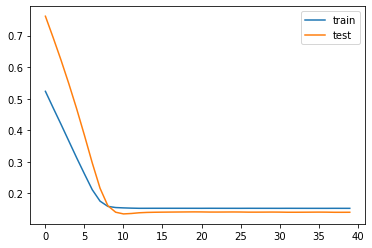

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()



In [18]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
scaler = MinMaxScaler(feature_range=(0, 1)).fit(inv_yhat)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.085


In [19]:
print(inv_yhat)

[0.72769523 0.73079824 0.74676134 0.7618272  0.77235778 0.77640021
 0.76953595 0.7828258  0.79088225 0.781503   0.78308361 0.78992627
 0.77846172 0.76770285 0.76450288 0.7675809  0.77125845 0.77537405
 0.78285274 0.77633095 0.76675722 0.76294186 0.75738142 0.75308245
 0.75239208 0.7475446  0.72674286 0.71260866 0.71729775 0.71660144
 0.71437884 0.71037951 0.71252237 0.71330023 0.71599343 0.71679423
 0.71472806 0.71582185 0.7164466  0.72761021 0.74135812 0.74723476
 0.74466272 0.74371689 0.75834391 0.7742093  0.78583106 0.80346328
 0.78869554 0.78391425 0.79270495 0.84451208 0.88115402 0.88732293
 0.88581379 0.87285852 0.85750019 0.84678684 0.8374321  0.8463265
 0.84410371 0.83299067 0.82066942 0.80888447 0.78951053 0.78660127
 0.78656405 0.76970603 0.7771308  0.77099791 0.77166255 0.78067695
 0.79746614 0.81177084 0.80155955 0.78645273 0.76828225 0.75193471
 0.74665164 0.74472193 0.73876593 0.73401155 0.72282394 0.72202329
 0.71762706 0.71410079 0.72820839 0.73198431 0.72754747 0.73357

In [20]:
look_back = 1
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

NameError: name 'trainPredict' is not defined